To demonstrate how to run the code, we'll generate some random data. This is just to showcase the shape and type of the inputs; the result will not make much sense.
We draw spike counts from a uniform random distribution, labels from a random categorial distribution with 4 categories, and reaction times from a log-normal distribution. We then gather the spike counts, the bins used, as well as the name of each cell in a named tuple structure called ppsth (population PSTH).

In [37]:
using Printf

bins = range(-300.0, step=5.0, stop=300.0)
nbins = length(bins) 
locations = 1:4
cells_per_session = [13, 26, 14] 
trials_per_session = [134, 201,197]
nsessions = length(trials_per_session)
max_n_trials = maximum(trials_per_session) 
ncells = sum(cells_per_session)
counts = fill(0.0, nbins, max_n_trials, ncells)
labels = Vector{Vector{Int64}}(undef, ncells)
cellnames = Vector{String}(undef, ncells)
trialidx = Vector{Vector{Int64}}(undef, ncells)
rtimes = Dict{String,Vector{Float64}}()
sessions = Vector{String}(undef, nsessions)
offset = 0
day = "20231031"
for (i,(_ntrials, _ncells)) in enumerate(zip(trials_per_session, cells_per_session))
    counts[:,1:_ntrials, 1:_ncells] = rand(nbins, _ntrials, _ncells)
    sname = @sprintf "session%02d" i
    sessions[i] = joinpath("Animal",day, sname)
    rtimes[sessions[i]] = exp.(5.0 .+ 0.1*randn(_ntrials))
    for j in 1:_ncells
        cellname = @sprintf "cell%02d" j
        cellnames[offset+j] = joinpath("Animal",day, sname, "array01","channel001",cellname)
        trialidx[offset+j] = [1:_ntrials;] 
        labels[offset+j] = rand(locations, _ntrials)
    end
    offset += _ncells
end
# create some fake cell names
ppsth = (counts=counts, bins=bins, windowsize=1, cellnames=cellnames)

(counts = [0.4059171326128572 0.08003302672475587 … 0.696079791268711 0.995370573264103; 0.7787061271381649 0.9694530532999767 … 0.8296643773227649 0.012234951430940666; … ; 0.9208085751181464 0.9230299033857523 … 0.9679160260487261 0.8359980723504639; 0.5702388478735979 0.5511046898495862 … 0.9128781435900665 0.6872908882198451;;; 0.34775771073808925 0.05032443629760741 … 0.5978855795896182 0.22633272298884355; 0.8512590317074666 0.48165632563683225 … 0.8650534673549258 0.06852359176063427; … ; 0.5436230591526436 0.44347390044854373 … 0.3390670115351472 0.35094266567855503; 0.6034823005700463 0.8945656578361513 … 0.45674487733770586 0.8041194315368773;;; 0.7404661079272885 0.11244954990682543 … 0.4933411166687598 0.571390490872778; 0.47231440433273 0.4078032606895057 … 0.353767750521515 0.059904033643302323; … ; 0.2650782531878355 0.2409903912645066 … 0.8256706076316147 0.5458620245761884; 0.24934484855629224 0.7381902113751825 … 0.7391567752266491 0.33794164412286476;;; … ;;; 0.0 0.0

We can now train the event onset decoder to e.g. post-dict an event happening at 0ms. First we specify what latencies and window sizes we want to explore. Then we'll set the parameters for the decoder (see inline comments below). Finally, we'll do 10 runs for this tutorial, but in practice we should do at least 100 runs to get decent statistics.

In [45]:
using EventOnsetDecoding
using MultivariateStats

cellidx = 1:ncells
args = [sessions, locations, cellidx]
latencies = range(70.0, step=-10.0, stop=0.0)
windows = [range(5.0, step=10.0, stop=50.0);]
nruns = 10
kvs = [:nruns=>nruns, # number runs, i.e. number of different sets of training and testing trials
	   :difference_decoder=>true, # one of several possible decoders; the one used in the paper
	   :windows=>windows, # the window sizes used
	   :latencies=>latencies, # the latencies from the event to train/test at
	   :combine_locations=>true, # whether to combine responses from all categories
	   :use_area=>"ALL", # whether to use all cells, or a subset corresponding to a particular area
	   :rtime_min=>-Inf, # the minimum reaction time. Trial with shorter reaction times are excluded prior to 
	                     # training the decoder 
	   :mixin_postcue=>true, # used to increase the number of potential false postives. This tends to make
						  # the decoder more robust
	   :reverse_bins=true # indicates that we want to look backwards in time to the event at 0
	]
dargs = EventOnsetDecoding.DecoderArgs(args...;kvs..., baseline_end=-200.0)
rseeds = rand(UInt32,nruns)
perf,rr,f1score,fname = EventOnsetDecoding.run_rtime_decoder(ppsth,trialidx,labels,rtimes,dargs,
                                                             ;decoder=MultivariateStats.MulticlassLDA, rseeds=rseeds)

([0.0 0.0 … 0.0 0.0; 0.46938775510204084 0.0 … 0.0 0.0; … ; 0.4489795918367347 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.38596491228070173 0.0 … 0.0 0.0; … ; 0.2982456140350877 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.4358974358974359 0.0 … 0.0 0.0; … ; 0.4358974358974359 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.4583333333333333 0.0 … 0.0 0.0; … ; 0.4583333333333333 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.5777777777777777 0.0 … 0.0 0.0; … ; 0.4666666666666667 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.5208333333333334 0.0 … 0.0 0.0; … ; 0.2708333333333333 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.35294117647058826 0.0 … 0.0 0.0; … ; 0.2549019607843137 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.46511627906976744 0.0 … 0.0 0.0; … ; 0.3023255813953488 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;;; 0.0 0.0 … 0.0 0.0; 0.2653061224489796 0.0 … 0.0 0.0; … ; 0.46938775510204084 0.0 … 0.0 0.0; 0.0 

The outputs `perf` and `f1score` represent the performance of the decoder. In particular, `perf` shows the performance, i.e. the relative number of times that the decoder concluded that an event happened at each point in time. The first dimension represents the time points, the second and third the window and latency at which the decoder was trained, the fourth the category the decoder was tested on (if we trained the decoder on all categories, like in this example, this dimension was just be 1), and the fifth the runs. For each run, the decoder was trained on a different set of training and testing trials. The `f1score` variable represent the F1-score, i.e. a modified performance measure that takes the number of false negatives and false positives into account. The dimenions are similar to those of `perf`, with the exception that the `f1score` is not time resolved. It is only evaluated at the specific window size and latency.

To reproduce Figure 2A in the paper, we can plot the mean f1score.

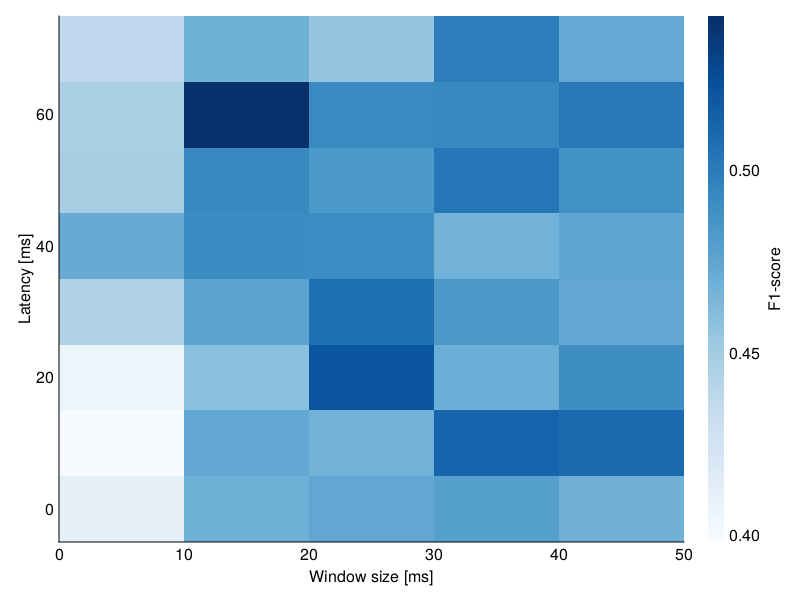

In [44]:
using Makie
using CairoMakie
using StatsBase

μ = dropdims(mean(f1score, dims=4), dims=(3,4))
with_theme(theme_minimal()) do 
    fig,ax,h = heatmap(windows, latencies, μ, colormap=:Blues)
    l = Colorbar(fig[1,2], h, label="F1-score")
    ax.xlabel = "Window size [ms]"
    ax.ylabel  = "Latency [ms]"
    fig
end

Since the input data was random, we see that most points are close to 0.5, i.e. chance level.